## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import sem
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [2]:
#Join tables on mouse ID
full_mice_data = pd.merge(study_results, mouse_metadata, on="Mouse ID", how="outer")

In [3]:
#Find each time instance
times = study_results['Timepoint'].unique()

#Will fill in this list with any duplicate mice to exclude
duplicates = []

#Initiate loop
for time in times:
    
    #Filter to each time period
    temp_time_df = study_results.loc[study_results['Timepoint'] == time, :]

    #Count the instances of each mouce during that time period
    #If a mouse is counted more than once, it's a duplicate
    temp_mice_count = pd.DataFrame([temp_time_df['Mouse ID'].value_counts()])

    temp_mice_count = temp_mice_count.transpose()

    #Filter to the duplicate mice (where count > 1)
    extra_mice = temp_mice_count.loc[temp_mice_count['Mouse ID'] > 1, :]

    #Add duplicate mouse ID to dupicate list
    if extra_mice.empty == False:
        for row in extra_mice:
            duplicates.append(extra_mice.index[0])
            

In [4]:
# Create a clean DataFrame by dropping all data associated with the duplicate mouse by its ID.

#Loop through each value in the duplicates list
for mouse in duplicates:
    
    #Select only those rows which do not contain the current iterated value in duplicates
    clean_mouse_data = full_mice_data.loc[full_mice_data["Mouse ID"] != mouse, :]
    
    #Also doing the same for the metadata table in case I need to use it separately later
    clean_metadata = mouse_metadata.loc[mouse_metadata["Mouse ID"] != mouse, :]


## Summary Statistics

In [5]:
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

#Get drug names for loop
drugs = clean_mouse_data["Drug Regimen"].unique()

#Headers on the summary table
summary_df = pd.DataFrame({"Drug": [], 
                          "Mean": [], "Median": [], "Variance": [], "Standard Deviation": [], "Standard Error": []})

#Begin loop for each drug
for drug in drugs:
    
    #Filter to a signle drug
    temp_drug_df = clean_mouse_data.loc[clean_mouse_data["Drug Regimen"] == drug, :]

    #Caluclate summary stats
    drug_mean = temp_drug_df["Tumor Volume (mm3)"].mean()
    drug_median = temp_drug_df["Tumor Volume (mm3)"].median()
    drug_variance = np.var(temp_drug_df["Tumor Volume (mm3)"])
    drug_stdev = np.std(temp_drug_df["Tumor Volume (mm3)"])
    drug_sem = sem(temp_drug_df["Tumor Volume (mm3)"])
    
    #Add each summary data point to the summary data frame
    summary_df = summary_df.append({"Drug": drug, "Mean": drug_mean, "Median": drug_median,
                                   "Variance": drug_variance, "Standard Deviation": drug_stdev,
                                   "Standard Error": drug_sem}, ignore_index=True)

#Set drug as index for clarity
summary_df.set_index('Drug', inplace = True)

summary_df

,Mean,Median,Variance,Standard Deviation,Standard Error
Drug,,,,,
Capomulin,40.675741,41.557809,24.839296,4.983904,0.329346
Ketapril,55.235638,53.698743,68.188930,8.257659,0.603860
Naftisol,54.331565,52.509285,65.817708,8.112811,0.596466
Infubinol,52.884795,51.820584,42.886388,6.548770,0.492236
Stelasyn,54.233149,52.431737,59.122106,7.689090,0.573111
Ramicane,40.216745,40.673236,23.383692,4.835669,0.320955
Zoniferol,53.236507,51.818479,48.266689,6.947423,0.516398
Propriva,52.320930,50.446266,43.555716,6.599675,0.544332
Placebo,54.033581,52.288934,60.830138,7.799368,0.581331


## Bar and Pie Charts

(0, 255)

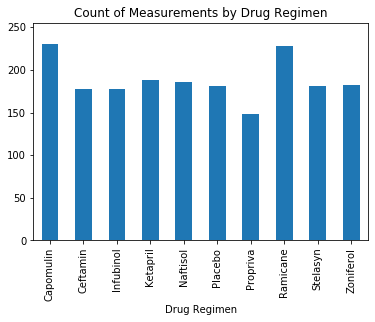

In [6]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.

#Group by drug to get counts
drugs_grouped = clean_mouse_data.groupby("Drug Regimen").count()

#Filter only to timepoint to count how many times each drug was administered
measurements_count = drugs_grouped["Timepoint"]

#Plot
measurements_count.plot(kind='bar')

#Adding Title, Limits, etc
plt.title("Count of Measurements by Drug Regimen")
plt.ylim(0, 255)


(0, 255)

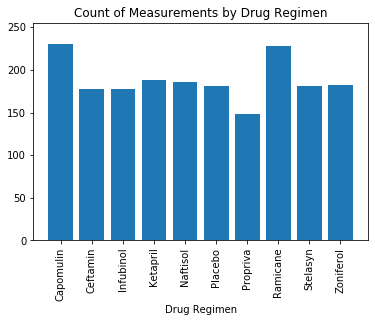

In [7]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.

#Set x-axis as numerical value (because I want to  adjust the tilt of the drug titles)
x_axis = np.arange(len(drugs))
tick_locations = [value for value in x_axis]

#Plot using plt.bar
plt.bar(tick_locations, measurements_count)

#Drugs list needs sorted alphabetically as that's how measurements_count is sorted
arr_drugs = np.sort(drugs)

#Set xticks to the drug regimen, rotated vertically
plt.xticks(tick_locations, arr_drugs, rotation="vertical")

#Adding Title, Limits, etc
plt.title("Count of Measurements by Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylim(0, 255)

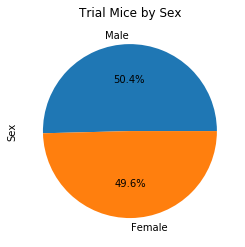

In [8]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

#Get sex data by value_counts on the sex column
sex_breakdown = clean_metadata['Sex'].value_counts()

#Plot (including title)
sex_breakdown.plot(kind='pie', autopct="%1.1f%%", title = 'Trial Mice by Sex')


Text(0.5, 1.0, 'Trial Mice by Sex')

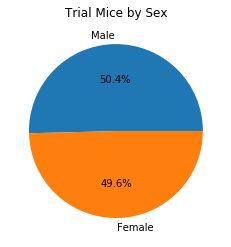

In [9]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

#Plot using the same sex_breakdown above
plt.pie(sex_breakdown, autopct="%1.1f%%", labels = ['Male', 'Female'])

#Set title
plt.title('Trial Mice by Sex')


## Quartiles, Outliers and Boxplots

In [10]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

#Create one blank list for each drug
capomulin_data = []
ramicane_data = []
infubinol_data = []
ceftamin_data = []

#Narow table to only the drugs specified
narrowed_mouse_data = clean_mouse_data.loc[(clean_mouse_data['Drug Regimen'] == 'Capomulin') |  
                                            (clean_mouse_data['Drug Regimen'] == 'Ramicane') |
                                            (clean_mouse_data['Drug Regimen'] == 'Infubinol') |
                                            (clean_mouse_data['Drug Regimen'] == 'Ceftamin'),:]

#Get all the mice into a list
narrowed_mice = narrowed_mouse_data['Mouse ID'].unique()

for mouse in narrowed_mice:
    
    #narrow to a specific mouse (will go in loop later)
    temp_mouse_data = narrowed_mouse_data.loc[narrowed_mouse_data['Mouse ID'] == mouse, :] 

    #Get the max time
    max_time = temp_mouse_data['Timepoint'].max()

    #Filter to last time
    max_mouse_data = temp_mouse_data.loc[temp_mouse_data['Timepoint'] == max_time, :]

    #Get tumor volume
    final_tumor_volume = max_mouse_data.iloc[0,2]

    #Conditional to put the volume in the correct drug list
    if max_mouse_data.iloc[0,4] == 'Capomulin':
       capomulin_data.append(final_tumor_volume)
    elif max_mouse_data.iloc[0,4] == 'Ramicane':
       ramicane_data.append(final_tumor_volume)
    elif max_mouse_data.iloc[0,4] == 'Infubinol':
       infubinol_data.append(final_tumor_volume)
    elif max_mouse_data.iloc[0,4] == 'Ceftamin':
       ceftamin_data.append(final_tumor_volume)


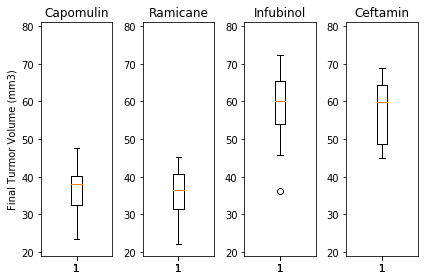

In [31]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#Set up the subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1 ,4, sharex=True)

#Pass each drugs data to a different subplot
#Include a ylim so that each drug is on the same scale

ax1.set_title('Capomulin')
ax1.set_ylabel('Final Turmor Volume (mm3)')
ax1.boxplot(capomulin_data)
ax1.set_ylim(19, 81)

ax2.set_title('Ramicane')
ax2.boxplot(ramicane_data)
ax2.set_ylim(19, 81)

ax3.set_title('Infubinol')
ax3.boxplot(infubinol_data)
ax3.set_ylim(19, 81)

ax4.set_title('Ceftamin')
ax4.boxplot(ceftamin_data)
ax4.set_ylim(19, 81)

plt.tight_layout()

## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
